# HW4 
In HW4 we first implement Gradient Descent Reinforecemnt Learning and then compare the convergence rate as well as max score to that of SARSA and Q learning.

## Derviation of gradient of log-probability for tabular policy

We assume that policy is given in tabular format such $$\pi(a|S_t, \theta) = \theta S_t$$
where $\theta$ is policy table and we assume $\theta_{as}$ is a,jth elemnt of matrix $\theta$. Now gradient of log probibility is computed as below.
\begin{bmatrix}
\theta_{11} & \theta_{12} & \dots & \theta_{1s} \\
\theta_{21} & \theta_{22} & \dots & \theta_{2s} \\
\vdots      & \vdots      &       & \vdots      \\
\theta_{a1} & \theta_{22} & \dots & \theta_{as} 
\end{bmatrix} \\

\begin{align}
    P(a|s, \theta) &= \frac{e^{\theta_{as}}}{\sum_{s^{'}} e^{\theta_{as^{'}}}} \\
    \log{P(a|s, \theta)} &= \theta_{as} - \log{\sum_{s^{'}} e^{\theta_{as^{'}}}} \\
    \frac{\partial}{\partial{\theta_{\overline{a}\overline{s}}}} \log{P(a|s, \theta)} &= \delta{a\overline{a}}\delta{s\overline{s}} - (\log{\sum_{s^{'}} e^{\theta_{as^{'}}}})^{-1}e^{\theta_{as^{'}}}\delta{s\overline{s}}
\end{align}\\




## Easy Grid World

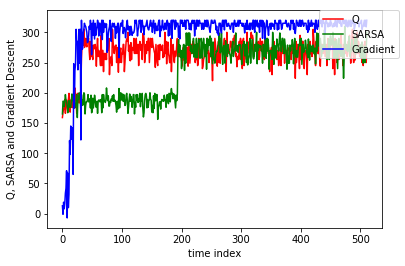

Q policy
[[2 1 1 2 2]
 [1 1 1 2 2]
 [1 1 2 2 2]
 [1 1 1 1 3]
 [0 0 1 0 0]]
SARSA policy
[[2 1 1 2 2]
 [1 1 1 1 3]
 [0 1 0 0 0]
 [1 0 0 1 0]
 [0 0 0 0 0]]
Gradient policy
[[2 2 2 2 2]
 [1 1 2 1 2]
 [2 2 1 2 2]
 [1 1 1 1 0]
 [0 1 1 1 0]]


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from GridWorld import GridWorld

# Saving an episode
class Memory(object):
    def __init__(self):
        self.state, self.action, self.reward = [], [], []

    def store_transition(self, state, action, reward):
        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)

    def convert_to_array(self):
        array_state = np.array(self.state)
        array_action = np.array(self.action)
        array_reward = np.array(self.reward)
        return array_state, array_action, array_reward

    def reset(self):
        self.state, self.action, self.reward= [], [], []

class PostProcess(object):
    def __init__(self):
        self.ep_reward = 0
        self.total_reward = []

    def rew_acu(self, reward):
        self.ep_reward = self.ep_reward + reward

    def push(self, episode):
        self.total_reward.append(self.ep_reward)
        #print('epoch',episode,' | reward', self.ep_reward)
        self.ep_reward = 0

    def graph(self):
        plt.plot(self.total_reward)
        plt.show()

    def get_reward(self):
        return self.total_reward

    def reset(self):
        self.ep_reward = 0
        self.total_reward = []

class Table(object):
    def __init__(self, state_dim, act_dim, lr):
        self.q_table = np.random.uniform(low= 0, high= 1, size= [act_dim, state_dim])
        self.lr = lr

    def policy_gen(self, state):
        y = self.q_table[:, state]
        policy_prob = np.divide(np.exp(y), np.sum(np.exp(y)))
        return policy_prob

    def gradeint_descent(self, state, action, g):
        x = np.zeros_like(self.q_table)
        y = np.zeros_like(self.q_table)

        x[action, state] = 1

        y[:, state] = np.exp(self.q_table[:, state])
        y = np.divide(y, np.sum(y))

        dJ = self.lr*g*(x - y)

        self.q_table = self.q_table + dJ

    def get_table(self):
        max_col = np.argmax(self.q_table, axis= 0)
        return np.reshape(max_col, newshape= [5, 5])



class Agent(object):
    def __init__(self, state_dim, act_dim, lr):
        self.table = Table(state_dim, act_dim, lr)
        self.v_weight = np.random.uniform(size= [25, 1])
        self.lr = lr
        self.memory = Memory()

    def get_action(self, state):
        policy = self.table.policy_gen(state)
        action = np.random.choice(range(4), p= policy.ravel())

        return action

    def update_policy(self, causality, baseline):
        state, action, reward = self.memory.convert_to_array()

        g = self.compute_g_value(reward)

        for t in range(batch_size):
            if baseline == 'on':
                v = self.compute_v_value(state[t])
            elif baseline == 'off':
                v = 0

            if causality == 'on':
                delta = g[0][t] - v
            elif causality == 'off':
                delta = np.sum(reward)/batch_size - v

            self.table.gradeint_descent(state[t], action[t], delta)
            self.update_v_weight(state[t], delta)

        self.memory.reset()

    def compute_g_value(self, reward):
        g_value = np.zeros_like(reward, dtype= np.float32)
        value = 0
        for t in reversed(range(0, len(reward))):
            value = value + reward[t]
            g_value[t] = value
        return [g_value[:, np.newaxis]]

    def compute_v_value(self, state):
        value= self.v_weight[state][0]
        return value
    
    def update_v_weight(self, state, delta):
        self.v_weight[state][0] += 0.01*delta

    

class Q:

    def __init__(self, s, a):

        self.state_num = s
        self.action_num = a
        self.action = None
        self.Q_value = np.zeros((s, a))
        self.alpha = np.ones((s, a))
        self.gamma = 0.95
        self.epsilon = 0.1

    def update(self, a, s, s_prime, r):

        self.Q_value[s][a] = self.Q_value[s][a] + \
        (r + self.gamma*np.amax(self.Q_value[s_prime][:]) \
        -self.Q_value[s][a])*(np.power(1/self.alpha[s][a],0.8))

        self.alpha[s][a] = self.alpha[s][a] + 1

    def greedy(self,s):

        greed_sel = np.random.random_sample()

        if greed_sel >= self.epsilon:
            action_rand = np.argmax(self.Q_value[s][:])
        else:
            action_rand = np.random.randint(low = 0, high = self.action_num)

        return action_rand

    def get_table(self):
        max_col = np.argmax(self.Q_value, axis= 1)
        return np.reshape(max_col, newshape= [5, 5])

class SARSA:

    def __init__(self, s, a):

        self.state_num = s
        self.action_num = a
        self.action = None
        self.Q_value = np.zeros((s, a))
        self.alpha = np.ones((s, a))
        self.gamma = 0.95
        self.epsilon = 0.1

    def update(self, a,a_prime, s, s_prime, r):

        self.Q_value[s][a] = self.Q_value[s][a] + \
        (r + self.gamma*self.Q_value[s_prime][a_prime] \
        -self.Q_value[s][a])*(np.power(1/self.alpha[s][a],0.8))

        self.alpha[s][a] = self.alpha[s][a] + 1

    def greedy(self,s):

        greed_sel = np.random.random_sample()

        if greed_sel >= self.epsilon:
            action_rand = np.argmax(self.Q_value[s][:])
        else:
            action_rand = np.random.randint(low = 0, high = self.action_num)

        return action_rand

    def get_table(self):
        max_col = np.argmax(self.Q_value, axis= 1)
        return np.reshape(max_col, newshape= [5, 5])


#initialize the environment
env = GridWorld()
#initialize learning module with number of states and action
state_dim = 25
action_dim = 4

#set number of episodes and time steps
episode_num = 512
time_horizon = 128
batch_size = 16

# define exploring agent
worker = Agent(state_dim, action_dim, 0.01)
s_worker = SARSA(state_dim, action_dim)
q_worker = Q(state_dim, action_dim)

gprocess = PostProcess()
qprocess = PostProcess()
sprocess = PostProcess()

#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        # Policy Gradient
        action = worker.get_action(observation_old)

        #run environment 
        observation, reward = env.step(action, 0)

        worker.memory.store_transition(observation_old, action, reward)

        observation_old = observation

        gprocess.rew_acu(reward)

        if (((t+1)%batch_size) == 0):
            worker.update_policy(causality= 'on', baseline= 'off')

    gprocess.push(i_episode)

#testing Q based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        # Q learning
        action = q_worker.greedy(observation_old)

        #run environment 
        observation, reward = env.step(action, 0)

        q_worker.update(action, observation_old, observation, reward)

        observation_old = observation

        qprocess.rew_acu(reward)


    qprocess.push(i_episode)

#testing SARSA based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()
    action_old = s_worker.greedy(observation_old)

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        #run environment 
        observation, reward = env.step(action_old, 0)

        # SARSA
        action = s_worker.greedy(observation)
        s_worker.update(action_old, action, observation_old, observation, reward)
        action_old = action
        observation_old = observation

        sprocess.rew_acu(reward)

    sprocess.push(i_episode)

Q_line = plt.plot(qprocess.get_reward(), 'r', label= 'Q')
S_line = plt.plot(sprocess.get_reward(), 'g', label= 'SARSA')
G_line = plt.plot(gprocess.get_reward(), 'b', label= 'Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.ylabel('Q, SARSA and Gradient Descent')
plt.xlabel('time index')

plt.show()

print('Q policy')
print(q_worker.get_table())

print('SARSA policy')
print(s_worker.get_table())

print('Gradient policy')
print(worker.table.get_table())

env.close()

## Hard GridWorld

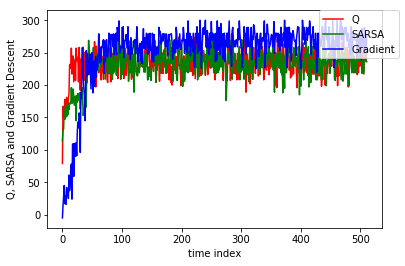

Q policy
[[1 1 2 2 2]
 [1 1 1 1 3]
 [0 1 0 1 0]
 [1 0 0 1 3]
 [1 1 0 0 3]]
SARSA policy
[[2 1 1 2 2]
 [1 1 1 1 2]
 [1 0 1 0 0]
 [1 1 0 0 0]
 [0 3 0 0 0]]
Gradient policy
[[1 1 2 1 2]
 [1 1 1 1 0]
 [0 1 0 0 2]
 [0 0 1 0 2]
 [0 1 1 0 0]]


In [7]:
# define exploring agent
worker = Agent(state_dim, action_dim, 0.01)
s_worker = SARSA(state_dim, action_dim)
q_worker = Q(state_dim, action_dim)

gprocess.reset()
qprocess.reset()
sprocess.reset()
#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        # Policy Gradient
        action = worker.get_action(observation_old)

        #run environment 
        observation, reward = env.step(action, 1)

        worker.memory.store_transition(observation_old, action, reward)

        observation_old = observation

        gprocess.rew_acu(reward)

        if (((t+1)%batch_size) == 0):
            worker.update_policy(causality= 'on', baseline= 'off')

    gprocess.push(i_episode)

#testing Q based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        # Q learning
        action = q_worker.greedy(observation_old)

        #run environment 
        observation, reward = env.step(action, 1)

        q_worker.update(action, observation_old, observation, reward)

        observation_old = observation

        qprocess.rew_acu(reward)


    qprocess.push(i_episode)

#testing SARSA based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()
    action_old = s_worker.greedy(observation_old)

    for t in range(time_horizon):

        #render the environment graphics
        #env.render()

        #run environment 
        observation, reward = env.step(action_old, 1)

        # SARSA
        action = s_worker.greedy(observation)
        s_worker.update(action_old, action, observation_old, observation, reward)
        action_old = action
        observation_old = observation

        sprocess.rew_acu(reward)

    sprocess.push(i_episode)

Q_line = plt.plot(qprocess.get_reward(), 'r', label= 'Q')
S_line = plt.plot(sprocess.get_reward(), 'g', label= 'SARSA')
G_line = plt.plot(gprocess.get_reward(), 'b', label= 'Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.ylabel('Q, SARSA and Gradient Descent')
plt.xlabel('time index')

plt.show()

print('Q policy')
print(q_worker.get_table())

print('SARSA policy')
print(s_worker.get_table())

print('Gradient policy')
print(worker.table.get_table())

env.close()